In this tutorial, we'll go over some of the functionality for searching and querying data for various objects.  We'll explore a module for searching for lists of objects from local data files, online databases, and querying MAST servers.  We'll also be using previously introduced modules to perform a bit of analysis on the objects.  In particular, the `downloads` and `k2fov` modules.

We'll start out with some of the more basic search functions.  The most basic search we can perform is one that uses a local file to list objects in a K2 campaign.  The function will rely on a target list file that comes with the library, but new ones may be downloaded from the Kepler website here: https://keplerscience.arc.nasa.gov/k2-approved-programs.html#campaign-8

We use the `data` module to get names of various data files that come with the library, and the queries.search module to read them easily.

In [1]:
from utilities import data
from utilities.queries import search

/home/rodot/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We use a target list file that I've personally edited to fill in a few missing data points that were taken after observation.  We'll later go over how that can be done with some of the other modules in this section.

The name of the constant pointing to this file in the `data` module is `FULL_TARGET_LIST`

In [2]:
print data.FULL_TARGET_LIST

/home/rodot/Documents/Research/Git-CARMA/utilities/../data/GO_all_campaigns_to_date_extra.csv


We'll use the `search_file` function in the `search` module to find all campaign 8 objects.  This function will return a dictionary of EPIC IDs pointing to a tuple of (KepMag, RA, DEC) for each object.

In [3]:
c8_objs = search.search_file(data.FULL_TARGET_LIST, campaign=8)
print c8_objs.items()[0]
print "Found {} objects".format(len(c8_objs))

(220463108, (11.659, 12.5045195, 5.9456959))
Found 29939 objects


Another way we can search object is by proposal.  We can use an online database of objects that have SFF processing to search for objects based on which proposal they came from.  The function takes a regular expression as the first argument to *search* by some proposal.  Giving it the input "GO" will search all proposals.  The function will again return a dictionary of the same structure as before.

In [4]:
c8_objs_sff = search.search_proposal('GO', campaign=8)
print c8_objs_sff.items()[0]
print "Found {} objects".format(len(c8_objs_sff))

(220463108, (11.659, 12.50452, 5.9456959))
Found 24137 objects


Notice there are slightly fewer objects in this data set, we we must be careful to make sure objects that we want SFF processings for are found within this resulting dictionary.

Now, sometimes we want a little more information about a particular object or set of objects, for this we would usually go to the MAST EPIC search online and query for objects, but I've written a nice little module to do this for us in python.  Much of the module contains helpful information regarding it's own API usage, so we'll look that over first.  

In [5]:
from utilities.queries import k2

For first instantiate a `Query` object that will allow us to obtain useful information about an object.

In [6]:
k2query = k2.Query()

The first thing we'll do is look over the available data fields we can query.  We can print out a nicely formatted table of data fields as well as their descriptions with the `print_fields` method.

In [7]:
k2query.print_fields()

----------------------+----------------+--------------------------+----------------------+-----------
     Column Name      |  Column Label  |       Description        |    Examples/Valid    |   Units    
                      |                |                          |        Values        |            
----------------------+----------------+--------------------------+----------------------+-----------
                      |                |     Non-unique K2 ID     |                      |            
                      |                |       identifying        |                      |            
                      |                |  corresponding entry in  |                      |            
                      |                |    EPIC or the custom    |                      |            
      ktc_k2_id       |     K2 ID      |   aperture file. Note    |     200000811 to     |  integer   
                      |                |  multiple observations   |      25

So let's do a simple example.  We'll query information about the first object we found from our search functions.  We'll just use the EPIC ID which corresponds to the `ktc_k2_id` column name in our query.  We pass a query to the `query_MAST` method by passing keyword arguments corresponding to query columns of strings representing a data value. The method will return a generator that iterates over input lines of a csv file returned by the query.  If an object cannot be found, the generator will be empty. More information about query subission syntax can be found here: https://archive.stsci.edu/vo/mast_services.html

In [8]:
epic_id = str(c8_objs.keys()[0])
print epic_id

query_result = k2query.query_MAST(ktc_k2_id=epic_id, sci_campaign=8)
for line in query_result:
    print line

220463108
['K2 ID', 'Dataset Name', 'Campaign', 'Object type', 'RA (J2000)', 'Dec (J2000)', 'Target Type', 'Ref', 'Actual Start Time', 'Actual End Time', 'Investigation ID', 'R Mag', 'R Mag Err', 'J Mag', 'J Mag Err', 'KEP Mag', 'Kep Flag', 'Hip ID', 'Tyc ID', 'SDSS ID', 'UCAC ID', '2MASS ID', '2MASS Flag', 'Module', 'Output', 'Channel', 'High-Level Science Products']
['integer', 'string', 'integer', 'substring', 'ra', 'dec', 'ustring', 'integer', 'datetime', 'datetime', 'string', 'float', 'float', 'float', 'float', 'float', 'string', 'integer', 'string', 'string', 'string', 'string', 'string', 'integer', 'integer', 'integer', 'integer']
['220463108', 'KTWO220463108-C08', '8', 'STAR', '00 50 01.086', '+05 56 44.51', 'LC', '', '2016-01-04 13:31:07', '2016-03-23 06:33:52', 'GO8032_GO8033_GO8068_GO8077', '11.645', '0.020', '10.772', '0.026', '11.659', 'gri', '', '', '', '480-001238', '00500109+0556446', 'AAA-222-111-000-0-0', '19', '2', '66', '13']


We see that the lines returned contain a header, a data type, and the actual data regarding the object.  We can see that now in addition to the magnitude and coordinates, we also have observation times, information from other surveys, and information about which HLSPs are available for the objects.

Now let's try a few objects so we can practice doing a larger search.  We'll use the first 10 EPIC IDs this time.  This time we pass a comma separated list of objects as our keyword argument.

In [9]:
epic_ids = ','.join(map(str, c8_objs.keys()[:10]))
print epic_ids

query_result = k2query.query_MAST(ktc_k2_id=epic_ids, sci_campaign=8)
for line in query_result:
    print line

220463108,220200969,220332050,220200979,220594200,229228971,220594217,220332083,220594185,220332091
['K2 ID', 'Dataset Name', 'Campaign', 'Object type', 'RA (J2000)', 'Dec (J2000)', 'Target Type', 'Ref', 'Actual Start Time', 'Actual End Time', 'Investigation ID', 'R Mag', 'R Mag Err', 'J Mag', 'J Mag Err', 'KEP Mag', 'Kep Flag', 'Hip ID', 'Tyc ID', 'SDSS ID', 'UCAC ID', '2MASS ID', '2MASS Flag', 'Module', 'Output', 'Channel', 'High-Level Science Products']
['integer', 'string', 'integer', 'substring', 'ra', 'dec', 'ustring', 'integer', 'datetime', 'datetime', 'string', 'float', 'float', 'float', 'float', 'float', 'string', 'integer', 'string', 'string', 'string', 'string', 'string', 'integer', 'integer', 'integer', 'integer']
['220200969', 'KTWO220200969-C08', '8', 'STAR', '00 50 02.101', '+00 01 49.47', 'LC', '', '2016-01-04 13:31:07', '2016-03-23 06:33:52', 'GO8031', '', '', '14.320', '0.030', '15.483', 'JHK', '', '', '', '451-001053', '00500211+0001496', 'AAA-222-111-000-0-0', '22',

Now we'll try a more general query.  We'll search for objects near a K2 field of view.  We'll go back to using the `k2fov` module to find the bounding box of a field, query objects within the box, then narrow down our list to object that were within the field of the CCD modules.

In [10]:
from utilities import k2fov

In [11]:
c8fov = k2fov.Field(8)
bounding_box = c8fov.bounding_box # given (top, right, bottom, left)
print bounding_box

(13.21342773732006, 24.337723771084242, -2.6967994617941984, 8.354398995491927)


In [12]:
ra_bounds = "{}..{}".format(bounding_box[3], bounding_box[1])
dec_bounds = "{}..{}".format(bounding_box[2], bounding_box[0])

print ra_bounds
print dec_bounds

# we'll make it a list so we can index it
query_result = list(k2query.query_MAST(sci_ra=ra_bounds, sci_dec=dec_bounds, sci_campaign=8))

print len(query_result)

8.35439899549..24.3377237711
-2.69679946179..13.2134277373
25002


So, there's a bit of a problem here.  MAST will only allow us to retrieve up to 2000 data points at a time.  This means we have to usually split up our queries into smaller ones and combine them later into a full list of points.  One way that we can do this is by searching smaller bounding boxes, for example, splitting up the bounding box recursively with a quad tree.

Since our query by default returns coordinates in sexigesimal format, we need to convert to degrees to work with k2fov `Field` objects.  Fortunately, we can add an option to our query to return coordinates in degress.  We can set the keyword argument `coordformat` to `'dec'` to return our coordinates in decimal degrees.

In [16]:
query_result = []
top, right, bottom, left = c8fov.bounding_box

def query_bounds(top, right, bottom, left, split='ra'):
    '''recursively build the list if a query returns 2000 objects'''
    
    ra_bounds = "{}..{}".format(left, right)
    dec_bounds = "{}..{}".format(bottom, top)
    query_result = list(k2query.query_MAST(sci_ra=ra_bounds, sci_dec=dec_bounds, coordformat='dec'))[2:]
    
    if len(query_result) == 2000: # too many objects returned
        
        if split == 'ra': # left right splitting
            dx = (right-left)/2
            dy = 0
            split = 'dec'
            
        elif split == 'dec': # top bottom splitting
            dx = 0
            dy = (top-bottom)/2
            split = 'ra'
            
        return query_bounds(top-dy, right-dx, bottom, left, split=split) + \
                query_bounds(top, right, bottom+dy, left+dx, split=split) # add the two queries together
    
    print "Queried ra={}, dec={}".format(ra_bounds, dec_bounds)
    print "  Found {} objects".format(len(query_result))
    return query_result
        
query_result = query_bounds(top, right, bottom, left)
print "Found {} objects!".format(len(query_result))

Queried ra=8.35439899549..16.3460613833, dec=-2.69679946179..13.2134277373
  Found 16789 objects
Queried ra=16.3460613833..24.3377237711, dec=-2.69679946179..13.2134277373
  Found 13213 objects
Found 30002 objects!


Now we'll further narrow down our objects to those that appear on the K2 campaign 8 field of view.  If you remember from the k2fov tutorial, a module and channel pair of (0,0) means the object does not lie within the field.  Since RA and DEC are the 4th and 5th columns respectively, we'll grab those columns for our coordinates.  

In [17]:
c8_fov_objs = []
coords_deg = {'in':[],'out':[]} # we'll hold onto the coordinates of the objects in and out of the field
for line in query_result:
    ra, dec = map(float, line[4:6])
    if c8fov.test_point(ra, dec) != (0,0): # is the object within a module?
        c8_fov_objs.append(line)
        coords_deg['in'].append((ra,dec))
    else:
        coords_deg['out'].append((ra,dec))
        
print "Found {} out of {} objects in campaign 8 field of view".format(len(c8_fov_objs), len(query_result))

Found 29942 out of 30002 objects in campaign 8 field of view


Nearly all of our objects were in the field of view!  We can take a look at where they are by plotting them on top of the field.

In [18]:
%matplotlib inline
from matplotlib.pyplot import subplots
import richardsplot as rplot

/home/rodot/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


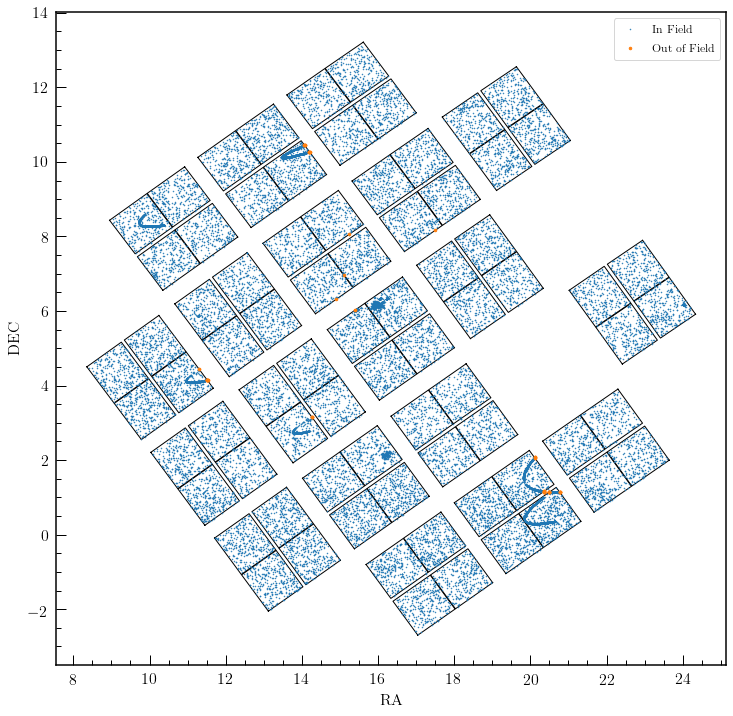

In [19]:

fig, ax = subplots(1,1, figsize=(12,12))
c8fov.plot_field(ax)

ras, decs = zip(*coords_deg['in'])
ax.plot(ras, decs, ls=' ', ms=1, marker='.', label='In Field')

ras, decs = zip(*coords_deg['out'])
ax.plot(ras, decs, ls=' ', ms=5, marker='.', label='Out of Field')

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.legend()